# Task 3

## Configuration

##Imports

In [7]:
!pip install git+https://github.com/openai/CLIP.git #Installing clip library

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vnuedbnd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vnuedbnd
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [8]:
import clip
from PIL import Image, ImageFilter, ImageOps
import numpy as np      # is ke ialwa ghar nahi chale ga
import matplotlib.pyplot as plt
import matplotlib
import cv2
import math    # small math helpers (ceil waghra)
import random           # reproducible shuffling
import copy          # deepcopy models for best chjkpnts
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim     # optimizers
from torch.amp import autocast
from torch.utils.data import Subset, DataLoader, ConcatDataset     # batched loading
from torchvision import datasets, transforms, models  #datasets + aug
from torchvision.transforms import functional as TF   # low level transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import defaultdict

matplotlib.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 600,
    "font.family": "DejaVu Serif",   # safe default
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.2
})

# # AMP compatibility shim (PyTorch <2.0 uses torch.cuda.amp.autocast; >=2.0 has torch.amp.autocast)
# use_amp = torch.cuda.is_available()

# try:
#     from torch.amp import autocast as _autocast_new  # PyTorch >= 2.0
#     def autocast_cuda():
#         # new API: torch.amp.autocast("cuda", dtype=...)
#         return _autocast_new("cuda", dtype=torch.float16, enabled=use_amp)
# except Exception:
#     from torch.cuda.amp import autocast as _autocast_old  # legacy API
#     def autocast_cuda():
#         # old API: torch.cuda.amp.autocast(enabled=..., dtype=...)
#         return _autocast_old(enabled=use_amp, dtype=torch.float16)
# SEED = config.seed
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.backends.cudnn.deterministic = True   # deterministic convs(slower)
# torch.backends.cudnn.benchmark = False      # disable autotuner for determinnsm

##Model (CLIP ViT-B/32)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip32, clipPreprocess = clip.load("ViT-B/32", device=device)

def count_params(m):
    return sum( p.numel() for p in m.parameters())/1e6

print(f"CLIP ViT-B/32 parameters: { count_params(clip32):.1f}M")

CLIP ViT-B/32 parameters: 151.3M


In [10]:
@torch.no_grad()
def evaluate_clip(model, loader, classnames, template="a photo of a {}"):
    model.eval()
    total, correct = 0, 0
    class_correct = [0 for _ in classnames]
    class_total = [0 for _ in classnames]

    texts = [template.format(c) for c in classnames]
    text_tokens = clip.tokenize(texts).to(device)
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        image_features = model.encode_image(imgs).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)

        logits = image_features @ text_features.T
        preds = logits.argmax(dim=1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        for l, p in zip(labels, preds):
            li = int(l.item())
            class_total[li] += 1
            if li == int(p.item()):
                class_correct[li] += 1

    overall_acc = correct / total if total else 0.0
    per_class_acc = [ (c/t) if t > 0 else 0.0 for c, t in zip(class_correct, class_total) ]
    return overall_acc, per_class_acc

## Dataset (PACS)

In [11]:
# DONT RUN IF YOU CAN MOUNT DRIVE PLZ YOUR TIME IS WORTH SOMETHING
# Run this command if havent unzipped PACS, make sure to upload the PACS zip to colab
# !unzip PACS.zip -d pacs_data

In [12]:
#Also, if you dont want to upload to colab repeatedly just mount drive
if not os.path.exists("/content/pacs_data"):
    from google.colab import drive
    drive.mount('/content/drive')
    print("Extracting PACS dataset...")
    !unzip -q /content/drive/MyDrive/PACS.zip -d /content/pacs_data
else:
    print("PACS dataset already exists, skipping unzip.")

Mounted at /content/drive
Extracting PACS dataset...


In [13]:
# # define transforms
# pacs_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                          std=[0.5, 0.5, 0.5])
# ])

# load a specific domain
def get_pacs_domain(root, domain, preprocess, batch_size=32, shuffle=True):
    domain_path = os.path.join(root, domain)
    dataset = datasets.ImageFolder(domain_path, transform=preprocess)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)
    return dataset, loader

root = "/content/pacs_data/kfold"

In [14]:
# domains = ["art_painting", "cartoon", "photo", "sketch"]
domains = ["photo", "art_painting", "cartoon", "sketch"]
prompts = ["a photo of a {}", "a painting of a {}", "a cartoon image of a {}", "a sketch of a {}"]
pacs_classes = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]

clip_dsets, clip_loaders = {}, {}

for d in domains:
    clip_dsets[d], clip_loaders[d]   = get_pacs_domain(root, d, clipPreprocess, batch_size=64)

##CLIP Zero-Shot vs Fine-tuned

In [15]:
#clip32 = clip32.float() #this needs to happen for some reason
clip32 = clip32.eval().to(device)  # keep CLIP in its native (fp16 on CUDA) dtype


###Training Linear Classifier on CLIP Embeddings on Source Domains (PAC)

In [16]:
def extract_features(model, loader):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            image_features = model.encode_image(imgs).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)
            feats.append(image_features.cpu())
            labels.append(lbls)
    feats = torch.cat(feats)
    labels = torch.cat(labels)
    return feats, labels


# Collect training features from P + A + C
train_domains = ["photo", "art_painting", "cartoon"]
train_feats, train_lbls = [], []
for d in train_domains:
    f, l = extract_features(clip32, clip_loaders[d])
    train_feats.append(f)
    train_lbls.append(l)
train_feats = torch.cat(train_feats)
train_lbls = torch.cat(train_lbls)

# Extract test features from S (sketch)
test_feats, test_lbls = extract_features(clip32, clip_loaders["sketch"])

print(f"Train features: {train_feats.shape}, Test features: {test_feats.shape}")

Train features: torch.Size([6062, 512]), Test features: torch.Size([3929, 512])


In [17]:
# Linear classifier
class LinearProbe(nn.Module):
    def __init__(self, feat_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(feat_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

feat_dim = train_feats.shape[1]
num_classes = len(pacs_classes)
clf = LinearProbe(feat_dim, num_classes).to(device)

In [18]:
optimizer = optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train_dataset = torch.utils.data.TensorDataset(train_feats, train_lbls)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

epochs = 10
for epoch in range(epochs):
    clf.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = clf(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        total += y.size(0)
        correct += (preds == y).sum().item()
        loss_sum += loss.item() * y.size(0)

    train_acc = correct / total
    avg_loss = loss_sum / total
    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc*100:.2f}% | Loss: {avg_loss:.4f}")

Epoch 1/10 | Train Acc: 72.73% | Loss: 1.8354
Epoch 2/10 | Train Acc: 93.63% | Loss: 1.6229
Epoch 3/10 | Train Acc: 95.22% | Loss: 1.4357
Epoch 4/10 | Train Acc: 96.07% | Loss: 1.2705
Epoch 5/10 | Train Acc: 96.32% | Loss: 1.1261
Epoch 6/10 | Train Acc: 96.72% | Loss: 1.0007
Epoch 7/10 | Train Acc: 96.92% | Loss: 0.8928
Epoch 8/10 | Train Acc: 96.93% | Loss: 0.8001
Epoch 9/10 | Train Acc: 97.06% | Loss: 0.7209
Epoch 10/10 | Train Acc: 97.16% | Loss: 0.6531


In [19]:
def domain_size(loader):
    return len(loader.dataset)

def weighted_avg(acc_by_domain, loaders_dict, domains_list):
    """
    acc_by_domain: dict[str -> accuracy]. Accuracies can be either in [0,1] or in [0,100].
    We normalize them to [0,1] before averaging. Weights = number of samples per domain.
    """
    # Gather accuracies in a list in domain order
    vals = [acc_by_domain[d] for d in domains_list]
    # Detect scale: if any value > 1, we assume percentages
    use_pct = any(v > 1.0 for v in vals)
    norm = (lambda v: v/100.0) if use_pct else (lambda v: v)

    weights = [len(loaders_dict[d].dataset) for d in domains_list]
    total_w = sum(weights)
    if total_w == 0:
        return 0.0
    num = sum(norm(acc_by_domain[d]) * len(loaders_dict[d].dataset) for d in domains_list)
    return num / total_w  # returns FRACTION in [0,1]

@torch.no_grad()
def evaluate_linear_probe(clf, model, loader):
    model.eval(); clf.eval()
    total, correct = 0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device); labels = labels.to(device)
        feats = model.encode_image(imgs).float()
        feats /= feats.norm(dim=-1, keepdim=True)
        logits = clf(feats)
        preds = logits.argmax(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    return correct / total if total else 0.0

###Comparison: CLIP Generic Prompt VS Domain-Specific Prompt VS Fine-tuned Linear Classifier (No Prompt)

In [20]:
print("=== Zero-Shot CLIP: Generic Prompt ===")
zs_generic = {}
for d in domains:
    acc, _ = evaluate_clip(clip32, clip_loaders[d], pacs_classes, template="a photo of a {}")
    zs_generic[d] = acc
    print(f"{d:<15} | Overall Accuracy: {acc*100:.2f}%")

src_domains = ["photo", "art_painting", "cartoon"]
tgt_domain  = "sketch"

print(f"\nWeighted SRC (generic): {weighted_avg(zs_generic, clip_loaders, src_domains)*100:.2f}%")
print(f"TARGET (generic, sketch): {zs_generic[tgt_domain]*100:.2f}%")

print("\n=== Zero-Shot CLIP: Domain-Specific Prompts ===")
domain_prompts = {
    "photo": "a photo of a {}",
    "art_painting": "a painting of a {}",
    "cartoon": "a cartoon image of a {}",
    "sketch": "a sketch of a {}",
}
zs_dom = {}
for d in domains:
    acc, _ = evaluate_clip(clip32, clip_loaders[d], pacs_classes, template=domain_prompts[d])
    zs_dom[d] = acc
    print(f"{d:<15} | Prompt: '{domain_prompts[d]}' | Overall Accuracy: {acc*100:.2f}%")

print(f"\nWeighted SRC (dom-spec): {weighted_avg(zs_dom, clip_loaders, src_domains)*100:.2f}%")
print(f"TARGET (dom-spec, sketch): {zs_dom[tgt_domain]*100:.2f}%")

=== Zero-Shot CLIP: Generic Prompt ===
photo           | Overall Accuracy: 99.70%
art_painting    | Overall Accuracy: 96.34%
cartoon         | Overall Accuracy: 97.78%
sketch          | Overall Accuracy: 84.91%

Weighted SRC (generic): 97.82%
TARGET (generic, sketch): 84.91%

=== Zero-Shot CLIP: Domain-Specific Prompts ===
photo           | Prompt: 'a photo of a {}' | Overall Accuracy: 99.70%
art_painting    | Prompt: 'a painting of a {}' | Overall Accuracy: 95.56%
cartoon         | Prompt: 'a cartoon image of a {}' | Overall Accuracy: 97.53%
sketch          | Prompt: 'a sketch of a {}' | Overall Accuracy: 85.11%

Weighted SRC (dom-spec): 97.46%
TARGET (dom-spec, sketch): 85.11%


In [21]:
print("\n=== Linear Probe (CLIP features) ===")
lp = {}
for d in domains:
    acc = evaluate_linear_probe(clf, clip32, clip_loaders[d])
    lp[d] = acc
    print(f"{d:<15} | Probe Accuracy: {acc*100:.2f}%")

print(f"\nWeighted SRC (probe): {weighted_avg(lp, clip_loaders, src_domains)*100:.2f}%")
print(f"TARGET (probe, sketch): {lp[tgt_domain]*100:.2f}%")



=== Linear Probe (CLIP features) ===
photo           | Probe Accuracy: 99.64%
art_painting    | Probe Accuracy: 94.14%
cartoon         | Probe Accuracy: 98.46%
sketch          | Probe Accuracy: 84.47%

Weighted SRC (probe): 97.33%
TARGET (probe, sketch): 84.47%


##Prompt Learning



Domain adaptation scenario, as we have access to unlabelled target data. We will use source and target images to automate prompt engineering to create the optimal prompt vector.

In [22]:
def _find_eot_pos(tokenized, eot_id=49407):
    # tokenized: [N, 77] int32
    # returns [N] long with the first index where token == eot_id
    # robust vs argmax hacks
    device = tokenized.device
    is_eot = (tokenized == eot_id)
    # if multiple eots, take the first
    idxs = is_eot.float().argmax(dim=1)
    return idxs.to(device)

class PromptLearner(nn.Module):
    """CoOp: shared context tokens"""
    def __init__(self, classnames, clip_model, ctx_len=4):
        super().__init__()
        self.classnames = classnames
        self.clip_model = clip_model
        self.ctx_len = ctx_len
        ctx_dim = clip_model.ln_final.weight.shape[0]

        # learnable context tokens
        emb_w = clip_model.token_embedding.weight
        self.ctx = nn.Parameter(torch.randn(ctx_len, ctx_dim,
                                            dtype=emb_w.dtype,
                                            device=emb_w.device))

        # tokenize class templates
        texts = [f"a photo of a {c}" for c in classnames]
        self.tokenized = clip.tokenize(texts)

    def forward(self):
        n_cls = len(self.classnames)

        # token embeddings (dtype follows CLIP text tower, usually fp16 on CUDA)
        with torch.no_grad():
            embedding = self.clip_model.token_embedding(
                self.tokenized.to(self.ctx.device)
            )  # [N_cls, 77, dim]  dtype = fp16

        # build ctx in SAME dtype
        ctx = self.ctx.unsqueeze(0).expand(n_cls, -1, -1).to(embedding.dtype)  # [N_cls, ctx_len, dim]
        prefix = embedding[:, :1, :]    # [N_cls, 1, dim]  fp16
        suffix = embedding[:, 1:, :]    # [N_cls, 76, dim] fp16

        prompts = torch.cat([prefix, ctx, suffix], dim=1)   # [N_cls, 1+ctx_len+76, dim]
        if prompts.size(1) < 77:
            pad_len = 77 - prompts.size(1)
            pad = torch.zeros(prompts.size(0), pad_len, prompts.size(2),
                              device=prompts.device, dtype=embedding.dtype)
            prompts = torch.cat([prompts, pad], dim=1)
        elif prompts.size(1) > 77:
            prompts = prompts[:, :77, :]

        pe = self.clip_model.positional_embedding[:prompts.size(1), :].to(embedding.dtype)
        x = prompts + pe

        with autocast("cuda", dtype=torch.float16):
            x = x.permute(1, 0, 2)
            x = self.clip_model.transformer(x)
            x = x.permute(1, 0, 2)
            x = self.clip_model.ln_final(x)

        tok = self.tokenized.to(x.device)
        eot_base = _find_eot_pos(tok)
        eot_shifted = (eot_base + self.ctx_len).clamp(max=prompts.size(1) - 1)

        text_features = x[torch.arange(x.shape[0], device=x.device), eot_shifted]
        proj = self.clip_model.text_projection
        text_features = text_features.to(proj.dtype)
        text_features = text_features @ proj
        text_features = F.normalize(text_features.float(), dim=-1)
        return text_features




class CoCoOp(nn.Module):
    """CoCoOp: image-conditioned context with caching and chunk support."""
    def __init__(self, classnames, clip_model, ctx_len=2, alpha=0.5, dropout=0.0):
        super().__init__()
        self.classnames = classnames
        self.clip_model = clip_model
        self.ctx_len = ctx_len
        self.alpha = float(alpha)
        ctx_dim = clip_model.ln_final.weight.shape[0]
        vis_dim = clip_model.visual.output_dim
        te_dtype = clip_model.token_embedding.weight.dtype
        dev = clip_model.token_embedding.weight.device

        # Pre-tokenize classes & cache token embeddings/prefix/suffix/pos as buffers
        tokenized = clip.tokenize([f"a photo of a {c}" for c in classnames]).to(dev)
        with torch.no_grad():
            emb = clip_model.token_embedding(tokenized)                     # [N_cls, 77, dim] fp16
        prefix = emb[:, :1, :].contiguous()                                 # [N_cls, 1, dim]
        suffix = emb[:, 1:, :].contiguous()                                 # [N_cls, 76, dim]
        pos = clip_model.positional_embedding[:77, :].to(te_dtype).contiguous()

        self.register_buffer("tokenized", tokenized, persistent=False)
        self.register_buffer("prefix_embed", prefix, persistent=False)
        self.register_buffer("suffix_embed", suffix, persistent=False)
        self.register_buffer("pos_embed", pos, persistent=False)

        # Base learnable context (shared across images)
        self.base_ctx = nn.Parameter(torch.randn(ctx_len, ctx_dim, dtype=te_dtype, device=dev))
        # Image-conditioned context MLP (fp16)
        self.image_proj = nn.Sequential(
            nn.Linear(vis_dim, ctx_dim, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(ctx_dim, ctx_dim, bias=True),
        ).to(te_dtype).to(dev)
        self.dropout = nn.Dropout(dropout)

    def forward(self, image_features, class_idx=None):
        """
        image_features: [B, Dv] (fp32 ok; cast inside)
        class_idx: Optional LongTensor [Nc] subset of classes
        returns [B, Nc, Dt]
        """
        dev = self.pos_embed.device
        te_dtype = self.pos_embed.dtype
        if class_idx is None:
            class_idx = torch.arange(self.tokenized.size(0), device=dev)
        elif not isinstance(class_idx, torch.Tensor):
            class_idx = torch.tensor(class_idx, device=dev, dtype=torch.long)
        Nc = class_idx.numel()
        B = image_features.size(0)

        # Select cached class embeddings
        prefix = self.prefix_embed.index_select(0, class_idx)   # [Nc, 1, dim] fp16
        suffix = self.suffix_embed.index_select(0, class_idx)   # [Nc, 76, dim] fp16
        pos = self.pos_embed                                   # [77, dim]    fp16

        # Build per-image conditioned context
        cond = self.image_proj(image_features.to(pos.dtype))    # [B, ctx_dim] fp16
        cond = cond.unsqueeze(1).expand(B, self.ctx_len, -1)    # [B, ctx_len, dim]
        base = self.base_ctx.to(pos.dtype).unsqueeze(0).expand(B, -1, -1)  # [B, ctx_len, dim]
        ctx_tokens = base + self.alpha * cond                   # [B, ctx_len, dim]
        ctx_tokens = self.dropout(ctx_tokens)
        ctx_tokens = ctx_tokens.unsqueeze(1).expand(B, Nc, self.ctx_len, -1)  # [B, Nc, ctx_len, dim]

        # Assemble prompts: [SOT] + ctx + (class + ... + EOT)
        prefix = prefix.unsqueeze(0).expand(B, -1, -1, -1)      # [B, Nc, 1, dim]
        suffix = suffix.unsqueeze(0).expand(B, -1, -1, -1)      # [B, Nc, 76, dim]
        prompts = torch.cat([prefix, ctx_tokens, suffix], dim=2)  # [B, Nc, 1+ctx_len+76, dim]
        L = prompts.size(2)
        if L < 77:
            pad_len = 77 - L
            pad = torch.zeros(B, Nc, pad_len, prompts.size(-1), device=prompts.device, dtype=pos.dtype)
            prompts = torch.cat([prompts, pad], dim=2)
        elif L > 77:
            prompts = prompts[:, :, :77, :]

        x = prompts + pos[:prompts.size(2), :]

        with autocast("cuda", dtype=torch.float16):
            x = x.permute(2, 0, 1, 3)                        # [L, B, Nc, dim]
            x = x.reshape(x.size(0), B * Nc, x.size(3))      # [L, B*Nc, dim]
            x = self.clip_model.transformer(x)
            x = x.permute(1, 0, 2)                           # [B*Nc, L, dim]
            x = self.clip_model.ln_final(x)

        # EOT index per class (shifted by ctx_len)
        eot_base = _find_eot_pos(self.tokenized)[class_idx]          # [Nc]
        eot_shifted = (eot_base + self.ctx_len).clamp(max=76)
        eot_shifted = eot_shifted.unsqueeze(0).expand(B, -1).reshape(-1)  # [B*Nc]

        idx = torch.arange(B * Nc, device=x.device)
        text_features = x[idx, eot_shifted]                 # [B*Nc, dim] fp16
        proj = self.clip_model.text_projection
        text_features = text_features.to(proj.dtype)
        text_features = text_features @ proj                # [B*Nc, Dt]
        text_features = text_features.view(B, Nc, -1).float()
        text_features = F.normalize(text_features, dim=-1)
        return text_features


In [23]:
def cocoop_logits_microbatch(clip_model, prompt_learner, feats, mb_size=8, cls_mb_size=3):
    logit_scale = clip_model.logit_scale.exp()
    B = feats.size(0)
    N_cls = prompt_learner.tokenized.size(0)
    outs = []
    for start in range(0, B, mb_size):
        end = min(start + mb_size, B)
        f = feats[start:end]
        row_chunks = []
        for c0 in range(0, N_cls, cls_mb_size):
            c1 = min(c0 + cls_mb_size, N_cls)
            class_idx = torch.arange(c0, c1, device=f.device, dtype=torch.long)
            text_b = prompt_learner(f, class_idx=class_idx)   # [b, cls_mb, D]
            logits_chunk = logit_scale * torch.bmm(
                f.unsqueeze(1), text_b.transpose(1, 2)
            ).squeeze(1)                                      # [b, cls_mb]
            row_chunks.append(logits_chunk)
        outs.append(torch.cat(row_chunks, dim=1))
    return torch.cat(outs, dim=0)

use_amp = True
def train_prompt_learner_DA(clip_model, source_loader, target_loader, classnames,
                            learner_type="coop", epochs=5, lr=5e-4, lambda_u=0.3, conf_thresh=0.7):
    if learner_type == "coop":
        prompt_learner = PromptLearner(classnames, clip_model).to(device)
    else:
        prompt_learner = CoCoOp(classnames, clip_model).to(device)

    for p in clip_model.parameters():
        p.requires_grad = False

    optimizer = optim.Adam(prompt_learner.parameters(), lr=lr)
    logit_scale = clip_model.logit_scale.exp().detach()  # scalar

    for epoch in range(epochs):
        prompt_learner.train()
        total_src, correct_src, loss_sum = 0, 0, 0.0

        src_iter = iter(source_loader)
        tgt_iter = iter(target_loader)

        for _ in range(len(source_loader)):
            try:
                imgs_s, labels_s = next(src_iter)
            except StopIteration:
                src_iter = iter(source_loader)
                imgs_s, labels_s = next(src_iter)
            try:
                imgs_t, _ = next(tgt_iter)
            except StopIteration:
                tgt_iter = iter(target_loader)
                imgs_t, _ = next(tgt_iter)

            imgs_s, labels_s = imgs_s.to(device), labels_s.to(device)
            imgs_t = imgs_t.to(device)

            # image features (frozen CLIP)
            with torch.no_grad(), autocast("cuda", dtype=torch.float16):
                feat_s = clip_model.encode_image(imgs_s)
                feat_t = clip_model.encode_image(imgs_t)
            feat_s = F.normalize(feat_s.float(), dim=-1)
            feat_t = F.normalize(feat_t.float(), dim=-1)

            # text features
            if learner_type == "cocoop":
                logits_s = cocoop_logits_microbatch(clip_model, prompt_learner, feat_s, mb_size=8, cls_mb_size=3)
            else:
                text = prompt_learner()             # [N_cls, D]
                logits_s = logit_scale * (feat_s @ text.T)

            loss_sup = F.cross_entropy(logits_s, labels_s)

            preds_s = logits_s.argmax(1)
            total_src += labels_s.size(0)
            correct_src += (preds_s == labels_s).sum().item()

            # ----- target unsupervised -----
            if learner_type == "cocoop":
                logits_t = cocoop_logits_microbatch(clip_model, prompt_learner, feat_t, mb_size=8, cls_mb_size=3)
            else:
                logits_t = logit_scale * (feat_t @ text.T)

            probs_t = logits_t.softmax(dim=1)
            confs, pseudo = probs_t.max(dim=1)

            # feature-space consistency (better than pixel-noise for deterministic preprocess)
            noise = 0.02 * torch.randn_like(feat_t)
            feat_t_aug = F.normalize(feat_t + noise, dim=-1)

            if learner_type == "cocoop":
                logits_t_aug = cocoop_logits_microbatch(clip_model, prompt_learner, feat_t_aug, mb_size=8, cls_mb_size=3)
            else:
                logits_t_aug = logit_scale * (feat_t_aug @ text.T)

            probs_t_aug = logits_t_aug.softmax(dim=1)
            loss_cons = F.mse_loss(probs_t, probs_t_aug)

            mask = confs > conf_thresh
            loss_pseudo = F.cross_entropy(logits_t[mask], pseudo[mask]) if mask.any() else torch.tensor(0.0, device=device)

            loss = loss_sup if epoch < 2 else (loss_sup + lambda_u * (loss_pseudo + loss_cons))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_sum += loss.item() * labels_s.size(0)

        acc_src = correct_src / total_src if total_src else 0.0
        print(f"[{learner_type.upper()}-DA] Epoch {epoch+1}/{epochs} | Src Acc: {acc_src*100:.2f}% | Loss: {loss_sum/total_src:.4f}")

    return prompt_learner


@torch.no_grad()
def eval_prompt_learner(clip_model, prompt_learner, loader):
    prompt_learner.eval()
    total, correct = 0, 0
    logit_scale = clip_model.logit_scale.exp()
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with autocast("cuda", dtype=torch.float16):
            image_features = clip_model.encode_image(imgs)
        image_features = F.normalize(image_features.float(), dim=-1)

        if isinstance(prompt_learner, CoCoOp):
            logits = cocoop_logits_microbatch(clip_model, prompt_learner, image_features, mb_size=16, cls_mb_size=3)
        else:
            text_features = prompt_learner()              # [N_cls, D]
            logits = logit_scale * (image_features @ text_features.T)

        preds = logits.argmax(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    return correct / total if total else 0.0


In [24]:
train_domains = ["photo", "art_painting", "cartoon"]
source_dataset = torch.utils.data.ConcatDataset([clip_loaders[d].dataset for d in train_domains])
source_loader = DataLoader(source_dataset, batch_size=64, shuffle=True)
target_loader = clip_loaders["sketch"]

# ---- Train CoOp-DA ----
coop_da = train_prompt_learner_DA(
    clip32, source_loader, target_loader, pacs_classes,
    learner_type="coop", epochs=5, lambda_u=0.5, conf_thresh=0.7
)

source_loader_coco = DataLoader(source_dataset, batch_size=24, shuffle=True, num_workers=2, pin_memory=True)
target_loader_coco = DataLoader(clip_dsets["sketch"], batch_size=24, shuffle=False, num_workers=2, pin_memory=True)

torch.cuda.empty_cache()
cocoop_da = train_prompt_learner_DA(
    clip32, source_loader_coco, target_loader_coco, pacs_classes,
    learner_type="cocoop", epochs=5, lambda_u=0.5, conf_thresh=0.7
)

# ---- Evaluate ----
acc_src_coop = eval_prompt_learner(clip32, coop_da, source_loader)
acc_tgt_coop = eval_prompt_learner(clip32, coop_da, target_loader)

acc_src_cocoop = eval_prompt_learner(clip32, cocoop_da, source_loader)
acc_tgt_cocoop = eval_prompt_learner(clip32, cocoop_da, target_loader)

Ns = len(source_loader.dataset)
Nt = len(target_loader.dataset)

overall_coop  = (acc_src_coop  * Ns + acc_tgt_coop  * Nt) / (Ns + Nt)
overall_coco  = (acc_src_cocoop* Ns + acc_tgt_cocoop* Nt) / (Ns + Nt)

print("\n==================== RESULTS ====================")
print(f"CoOp-DA   → Source: {acc_src_coop*100:.2f}% | Target: {acc_tgt_coop*100:.2f}% | Overall (weighted): {overall_coop*100:.2f}%")
print(f"CoCoOp-DA → Source: {acc_src_cocoop*100:.2f}% | Target: {acc_tgt_cocoop*100:.2f}% | Overall (weighted): {overall_coco*100:.2f}%")
print("=================================================")

[COOP-DA] Epoch 1/5 | Src Acc: 96.72% | Loss: 0.1352
[COOP-DA] Epoch 2/5 | Src Acc: 97.89% | Loss: 0.0831
[COOP-DA] Epoch 3/5 | Src Acc: 98.07% | Loss: 0.1001
[COOP-DA] Epoch 4/5 | Src Acc: 98.14% | Loss: 0.0948
[COOP-DA] Epoch 5/5 | Src Acc: 98.20% | Loss: 0.0913
[COCOOP-DA] Epoch 1/5 | Src Acc: 98.14% | Loss: 0.0626
[COCOOP-DA] Epoch 2/5 | Src Acc: 98.58% | Loss: 0.0439
[COCOOP-DA] Epoch 3/5 | Src Acc: 98.73% | Loss: 0.0541
[COCOOP-DA] Epoch 4/5 | Src Acc: 98.98% | Loss: 0.0430
[COCOOP-DA] Epoch 5/5 | Src Acc: 99.24% | Loss: 0.0356

==================== RESULTS ====================
CoOp-DA   → Source: 98.19% | Target: 87.63% | Overall (weighted): 94.03%
CoCoOp-DA → Source: 99.46% | Target: 87.76% | Overall (weighted): 94.86%


In [25]:
# def whos_biggest(n=10):
#     import sys
#     vars_with_size = []
#     for name, obj in globals().items():
#         try:
#             vars_with_size.append((name, sys.getsizeof(obj)))
#         except:
#             pass
#     for name, size in sorted(vars_with_size, key=lambda x: -x[1])[:n]:
#         print(f"{name:30s} {size/1024/1024:10.2f} MB")
# whos_biggest()
torch.cuda.empty_cache()

##Gradient Conflict and Alignment

In [26]:
def compute_grad_similarity(grads1, grads2):
    """Flatten and compute cosine similarity in fp32 between two gradient lists."""
    g1 = torch.cat([g.detach().float().reshape(-1) for g in grads1 if g is not None])
    g2 = torch.cat([g.detach().float().reshape(-1) for g in grads2 if g is not None])
    # guard against zero vectors
    if g1.norm() == 0 or g2.norm() == 0:
        return 0.0
    return F.cosine_similarity(g1.unsqueeze(0), g2.unsqueeze(0)).item()


# def get_prompt_grads(prompt_learner):
#     """Extract gradient tensors for prompt parameters."""
#     grads = []
#     for p in prompt_learner.parameters():
#         if p.grad is not None:
#             grads.append(p.grad.detach().clone())
#     return grads

In [29]:
def grads_of(loss, params):
    """
    autograd.grad with allow_unused=True and zero-fill,
    so we never crash if a param wasn't used this step.
    """
    raw = torch.autograd.grad(
        loss, params,
        retain_graph=False, create_graph=False,
        allow_unused=True
    )
    out = []
    for p, g in zip(params, raw):
        if g is None:
            out.append(torch.zeros_like(p))
        else:
            out.append(g)
    return out

def train_coop_with_grad_analysis(clip_model, loaders, classnames, epochs=5, lr=5e-4):
    """
    Train CoOp on two domains ('photo', 'art_painting'), measure cosine similarity
    between per-domain prompt gradients each step. Uses autograd.grad safely and
    applies the averaged gradient.
    """
    prompt_learner = PromptLearner(classnames, clip_model).to(device)
    optimizer = torch.optim.Adam(prompt_learner.parameters(), lr=lr)
    logit_scale = clip_model.logit_scale.exp().detach()

    sims_per_step, accs_per_step = [], []
    epoch_means = []

    for epoch in range(epochs):
        prompt_learner.train()
        iterP = iter(loaders["photo"])
        iterA = iter(loaders["art_painting"])
        num_steps = min(len(loaders["photo"]), len(loaders["art_painting"]))

        # compute grads only for params that actually require grad
        params = [p for p in prompt_learner.parameters() if p.requires_grad]

        for _ in range(num_steps):
            imgs_p, lbls_p = next(iterP); imgs_a, lbls_a = next(iterA)
            imgs_p, lbls_p = imgs_p.to(device), lbls_p.to(device)
            imgs_a, lbls_a = imgs_a.to(device), lbls_a.to(device)

            with torch.no_grad(), autocast("cuda", dtype=torch.float16):
                feat_p = clip_model.encode_image(imgs_p)
                feat_a = clip_model.encode_image(imgs_a)
            feat_p = F.normalize(feat_p.float(), dim=-1)
            feat_a = F.normalize(feat_a.float(), dim=-1)

            # domain P
            text_p = prompt_learner()
            logits_p = logit_scale * (feat_p @ text_p.T)
            loss_p = F.cross_entropy(logits_p, lbls_p)
            grads_p = grads_of(loss_p, params)

            # domain A
            text_a = prompt_learner()
            logits_a = logit_scale * (feat_a @ text_a.T)
            loss_a = F.cross_entropy(logits_a, lbls_a)
            grads_a = grads_of(loss_a, params)

            # cosine sim (fp32)
            sim = compute_grad_similarity(grads_p, grads_a)
            sims_per_step.append(sim)

            # step accuracy on union batch (0..1)
            preds = torch.cat([logits_p.argmax(1), logits_a.argmax(1)])
            lbls  = torch.cat([lbls_p, lbls_a])
            acc = (preds == lbls).float().mean().item()
            accs_per_step.append(acc)

            # apply average gradient
            avg_grads = [0.5 * (gp + ga) for gp, ga in zip(grads_p, grads_a)]
            optimizer.zero_grad(set_to_none=True)
            for p, g in zip(params, avg_grads):
                p.grad = g
            optimizer.step()
        epoch_mean = float(np.mean(sims_per_step[-num_steps:]))
        epoch_means.append(epoch_mean)
        print(f"[E{epoch+1}] GradSim mean (epoch): {epoch_mean:.3f} | "
              f"Step-Acc mean: {np.mean(accs_per_step[-num_steps:])*100:.2f}%")

    return prompt_learner, sims_per_step, accs_per_step, epoch_means



def train_coop_with_pga(clip_model, loaders, classnames, epochs=5, lr=5e-4):
    """
    PCGrad/PGA-style: project ga off gp if they conflict, then apply 0.5*(gp + ga_proj).
    """
    prompt_learner = PromptLearner(classnames, clip_model).to(device)
    optimizer = torch.optim.Adam(prompt_learner.parameters(), lr=lr)
    logit_scale = clip_model.logit_scale.exp().detach()
    eps = 1e-12

    for epoch in range(epochs):
        prompt_learner.train()
        iterP = iter(loaders["photo"])
        iterA = iter(loaders["art_painting"])
        num_steps = min(len(loaders["photo"]), len(loaders["art_painting"]))

        total_correct, total = 0, 0
        params = [p for p in prompt_learner.parameters() if p.requires_grad]

        for _ in range(num_steps):
            imgs_p, lbls_p = next(iterP); imgs_a, lbls_a = next(iterA)
            imgs_p, lbls_p = imgs_p.to(device), lbls_p.to(device)
            imgs_a, lbls_a = imgs_a.to(device), lbls_a.to(device)

            with torch.no_grad(), autocast("cuda", dtype=torch.float16):
                feat_p = clip_model.encode_image(imgs_p)
                feat_a = clip_model.encode_image(imgs_a)
            feat_p = F.normalize(feat_p.float(), dim=-1)
            feat_a = F.normalize(feat_a.float(), dim=-1)

            # grads per domain
            text_p = prompt_learner()
            logits_p = logit_scale * (feat_p @ text_p.T)
            loss_p = F.cross_entropy(logits_p, lbls_p)
            gp = grads_of(loss_p, params)

            text_a = prompt_learner()
            logits_a = logit_scale * (feat_a @ text_a.T)
            loss_a = F.cross_entropy(logits_a, lbls_a)
            ga = grads_of(loss_a, params)

            # PCGrad: project ga onto the normal plane of gp if cos<0
            ga_proj = []
            for g1, g2 in zip(gp, ga):
                v1 = g1.detach().float().reshape(-1)
                v2 = g2.detach().float().reshape(-1)
                if v1.norm() > 0 and v2.norm() > 0:
                    cos = torch.dot(v1, v2) / (v1.norm() * v2.norm() + eps)
                    if cos.item() < 0:
                        proj = (torch.dot(v2, v1) / (torch.dot(v1, v1) + eps)) * v1
                        v2 = v2 - proj
                ga_proj.append(v2.view_as(g2).to(g2.dtype))

            optimizer.zero_grad(set_to_none=True)
            for p, g1, g2 in zip(params, gp, ga_proj):
                p.grad = 0.5 * (g1 + g2)
            optimizer.step()

            preds = torch.cat([logits_p.argmax(1), logits_a.argmax(1)])
            lbls  = torch.cat([lbls_p, lbls_a])
            total_correct += (preds == lbls).sum().item()
            total += lbls.size(0)

        print(f"[PGA-E{epoch+1}] Src Acc over steps: {100*total_correct/total:.2f}%")

    return prompt_learner


[E1] GradSim mean (epoch): 0.795 | Step-Acc mean: 91.13%
[E2] GradSim mean (epoch): 0.827 | Step-Acc mean: 94.41%
[E3] GradSim mean (epoch): 0.846 | Step-Acc mean: 96.43%
[E4] GradSim mean (epoch): 0.754 | Step-Acc mean: 96.81%
[E5] GradSim mean (epoch): 0.571 | Step-Acc mean: 97.07%


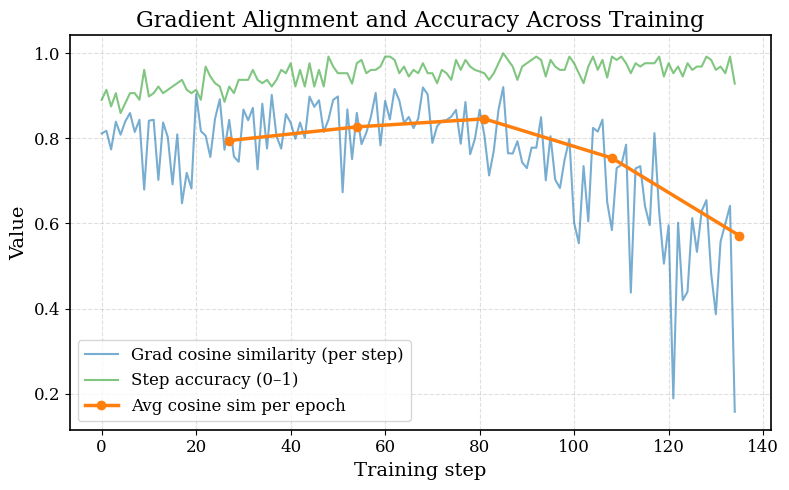

[PGA-E1] Src Acc over steps: 96.23%
[PGA-E2] Src Acc over steps: 97.26%
[PGA-E3] Src Acc over steps: 97.65%
[PGA-E4] Src Acc over steps: 98.06%
[PGA-E5] Src Acc over steps: 97.62%


In [32]:
loaders_PA = {
    "photo": clip_loaders["photo"],
    "art_painting": clip_loaders["art_painting"]
}

# (1) Normal CoOp with gradient tracking
coop_norm, sims, accs, epoch_means = train_coop_with_grad_analysis(clip32, loaders_PA, pacs_classes, epochs=5)

# rescale cosine sim from [-1,1] -> [0,1]
#sims_01 = [(s + 1.0) / 2.0 for s in sims]

plt.figure(figsize=(8,5))

# Step-level similarity and accuracy
plt.plot(sims, label="Grad cosine similarity (per step)", color='tab:blue', alpha=0.6)
plt.plot(accs, label="Step accuracy (0–1)", color='tab:green', alpha=0.6)

# Epoch-level means overlayed as thicker points/lines
epoch_steps = np.linspace(0, len(sims), len(epoch_means) + 1, endpoint=True)
plt.plot(epoch_steps[1:], epoch_means, 'o-', color='tab:orange', linewidth=2.5,
         markersize=6, label="Avg cosine sim per epoch")

plt.xlabel("Training step")
plt.ylabel("Value")
#plt.xticks(epoch_steps, [f"E{i+1}" for i in range(len(epoch_means))])
plt.title("Gradient Alignment and Accuracy Across Training")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# (2) CoOp with PGA
coop_pga = train_coop_with_pga(clip32, loaders_PA, pacs_classes, epochs=5)

# --- Evaluate on Source (P+A) and Target (Sketch) ---
source_concat = torch.utils.data.ConcatDataset([clip_loaders["photo"].dataset, clip_loaders["art_painting"].dataset])
src_loader = DataLoader(source_concat, batch_size=64, shuffle=False)
tgt_loader = clip_loaders["sketch"]

In [33]:
acc_src_norm = eval_prompt_learner(clip32, coop_norm, src_loader)
acc_tgt_norm = eval_prompt_learner(clip32, coop_norm, tgt_loader)
acc_src_pga = eval_prompt_learner(clip32, coop_pga, src_loader)
acc_tgt_pga = eval_prompt_learner(clip32, coop_pga, tgt_loader)

print("\n================== RESULTS ==================")
print(f"Normal CoOp → Src: {acc_src_norm*100:.2f}% | Tgt (Sketch): {acc_tgt_norm*100:.2f}%")
print(f"PGA-CoOp    → Src: {acc_src_pga*100:.2f}% | Tgt (Sketch): {acc_tgt_pga*100:.2f}%")
print("=============================================")


================== RESULTS ==================
Normal CoOp → Src: 96.99% | Tgt (Sketch): 79.82%
PGA-CoOp    → Src: 97.58% | Tgt (Sketch): 88.50%


##Open-Set and Generalization Analysis

In [34]:
n_total = len(pacs_classes)
n_seen = int(np.floor(0.8 * n_total))
seen_idxs = list(range(n_seen))
unseen_idxs = list(range(n_seen, n_total))
seen_classes = [pacs_classes[i] for i in seen_idxs]
unseen_classes = [pacs_classes[i] for i in unseen_idxs]
print("Seen:", seen_classes, "Unseen:", unseen_classes)

# --- 2. helper: filter a dataset (ImageFolder) to only include specified original class indices ---
def subset_indices_for_classes(dataset, allowed_idxs):
    return [i for i, t in enumerate(dataset.targets) if int(t) in allowed_idxs]

# Build source train loader (photo+art+cartoon) but only seen classes
train_domains = ["photo", "art_painting", "cartoon"]
src_dsets = [clip_loaders[d].dataset for d in train_domains]
src_subsets = [Subset(ds, subset_indices_for_classes(ds, seen_idxs)) for ds in src_dsets]
source_seen_ds = ConcatDataset(src_subsets)
source_seen_loader = DataLoader(source_seen_ds, batch_size=64, shuffle=True, num_workers=2)

# Build full-eval loaders (all classes) for source and target (sketch)
full_src_ds = ConcatDataset([clip_loaders[d].dataset for d in train_domains])
full_src_loader = DataLoader(full_src_ds, batch_size=64, shuffle=False, num_workers=2)
_, sketch_loader = get_pacs_domain(root, "sketch", clipPreprocess, batch_size=64, shuffle=False)

Seen: ['dog', 'elephant', 'giraffe', 'guitar', 'horse'] Unseen: ['house', 'person']


In [35]:
print("\nTraining CoOp (seen-only)...")
coop_seen = PromptLearner(seen_classes, clip32, ctx_len=4).to(device)
with torch.no_grad():
    # use a stable prefix embedding to initialize ctx (much better than pure noise)
    probe_text = [f"a photo of a {seen_classes[0]}"]
    tok = clip.tokenize(probe_text).to(device)
    emb = clip32.token_embedding(tok)[0]             # [77, dim] (fp16 on cuda)
    # take the first few tokens after SOT as prefix (tokens for: "a photo of a")
    prefix = emb[1:1+coop_seen.ctx.size(0), :]       # [ctx_len, dim]
    # small noise so different rows aren't identical
    init = prefix + 0.01 * torch.randn_like(prefix)
    init = init.to(coop_seen.ctx.dtype)
    coop_seen.ctx.copy_(init)
# train supervised: reuse train loop but simpler (no unlabeled target use)
def train_supervised_on_seen(prompt_module, clip_model, loader, epochs=5, lr=1e-4):
    # freeze all CLIP params; only prompt_module (ctx) gets grads
    for p in clip_model.parameters():
        p.requires_grad = False

    prompt_module.train()
    opt = torch.optim.Adam(prompt_module.parameters(), lr=lr, weight_decay=5e-4)
    seen_map = {orig: i for i, orig in enumerate(seen_idxs)}
    logit_scale = clip_model.logit_scale.exp().detach()

    for e in range(epochs):
        tot, corr = 0, 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            mapped = torch.tensor([seen_map[int(l.item())] for l in labels], device=device)

            with torch.no_grad():
                img_feats = clip_model.encode_image(imgs).float()
            img_feats = F.normalize(img_feats, dim=-1)

            text_feats = prompt_module()  # CoOp: no args
            logits = logit_scale * (img_feats @ text_feats.T)
            # label smoothing helps reduce overconfidence and improves OOD behavior
            loss = F.cross_entropy(logits, mapped, label_smoothing=0.1)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(prompt_module.parameters(), max_norm=1.0)
            opt.step()

            preds = logits.argmax(1)
            tot += mapped.size(0)
            corr += (preds == mapped).sum().item()
        print(f"Epoch {e+1}/{epochs}  Train acc (seen-only): {100.0 * corr / max(tot,1):.2f}%")
    return prompt_module

coop_seen = train_supervised_on_seen(coop_seen, clip32, source_seen_loader, epochs=5, lr=5e-4)


Training CoOp (seen-only)...
Epoch 1/5  Train acc (seen-only): 97.90%
Epoch 2/5  Train acc (seen-only): 98.03%
Epoch 3/5  Train acc (seen-only): 98.13%
Epoch 4/5  Train acc (seen-only): 98.34%
Epoch 5/5  Train acc (seen-only): 98.29%


In [36]:
@torch.no_grad()
def per_class_acc(loader, text_feats):
    C = text_feats.shape[0]
    corr = [0]*C; tot = [0]*C
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        f = clip32.encode_image(imgs).float(); f = f / f.norm(dim=-1, keepdim=True)
        logits = (f @ text_feats.T) * clip32.logit_scale.exp()
        preds = logits.argmax(1)
        for l,p in zip(labels.cpu().numpy(), preds.cpu().numpy()):
            tot[int(l)] += 1
            if int(l)==int(p): corr[int(l)] += 1
    per = [ (c/t if t>0 else 0.0) for c,t in zip(corr, tot) ]
    return per

@torch.no_grad()
def per_class_table(loader, zs_feats, coop_feats):
    per_zs   = per_class_acc(loader, zs_feats)
    per_coop = per_class_acc(loader, coop_feats)
    print("\nPer-class accuracy (Source domains P+A+C)")
    print("Class                Seen?   Zero-shot    CoOp(seen-only)")
    print("-"*58)
    for i, cname in enumerate(pacs_classes):
        tag = "seen  " if i in seen_idxs else "unseen"
        print(f"{cname:<20s} {tag:>6s}   {per_zs[i]*100:7.2f}%      {per_coop[i]*100:7.2f}%")


@torch.no_grad()
def full_text_features_from_prompt(prompt_module, seen_classes, unseen_classes):
    """
    Build [C_all, d] text feature matrix for evaluation:
      - seen classes: use learned CoOp prompt
      - unseen classes: use zero-shot CLIP text embeddings
    Output order matches `pacs_classes`.
    """
    # learned features for seen classes (in seen_classes order)
    seen_text_feats = prompt_module()  # [C_seen, d]; PromptLearner ignores image features

    # zero-shot for unseen
    tok_un = clip.tokenize([f"a photo of a {c}" for c in unseen_classes]).to(device)
    unseen_feats = clip32.encode_text(tok_un).float()
    unseen_feats = unseen_feats / unseen_feats.norm(dim=-1, keepdim=True)

    # assemble in pacs_classes order
    all_feats = []
    s_i = 0; u_i = 0
    for i in range(len(pacs_classes)):
        if i in seen_idxs:
            all_feats.append(seen_text_feats[s_i].unsqueeze(0)); s_i += 1
        else:
            all_feats.append(unseen_feats[u_i].unsqueeze(0)); u_i += 1
    all_feats = torch.cat(all_feats, dim=0)
    all_feats = all_feats / (all_feats.norm(dim=-1, keepdim=True) + 1e-10)
    return all_feats


# zero-shot full-class text features (baseline)
tok_all = clip.tokenize([f"a photo of a {c}" for c in pacs_classes]).to(device)
zs_all_feats = clip32.encode_text(tok_all).float(); zs_all_feats = zs_all_feats / zs_all_feats.norm(dim=-1, keepdim=True)

coop_all_feats = full_text_features_from_prompt(coop_seen, seen_classes, unseen_classes)
per_class_table(full_src_loader, zs_all_feats, coop_all_feats)


Per-class accuracy (Source domains P+A+C)
Class                Seen?   Zero-shot    CoOp(seen-only)
----------------------------------------------------------
dog                  seen       96.45%        90.70%
elephant             seen       98.25%        98.14%
giraffe              seen       97.66%        97.66%
guitar               seen       98.22%        96.44%
horse                seen       97.51%        95.17%
house                unseen     99.54%        99.42%
person               unseen     97.51%        91.14%


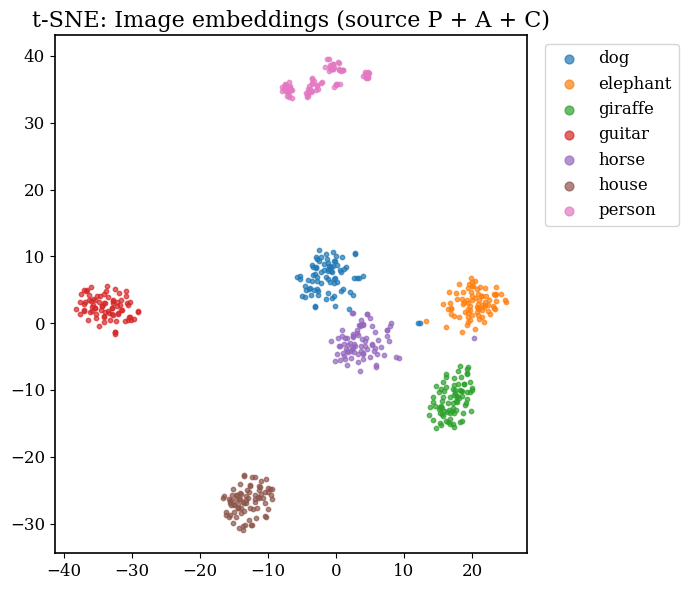

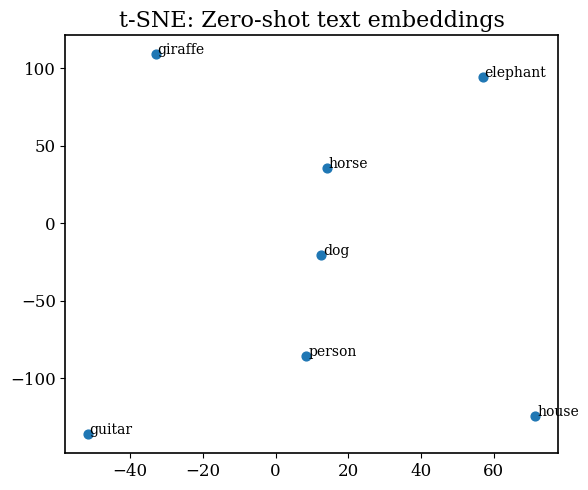

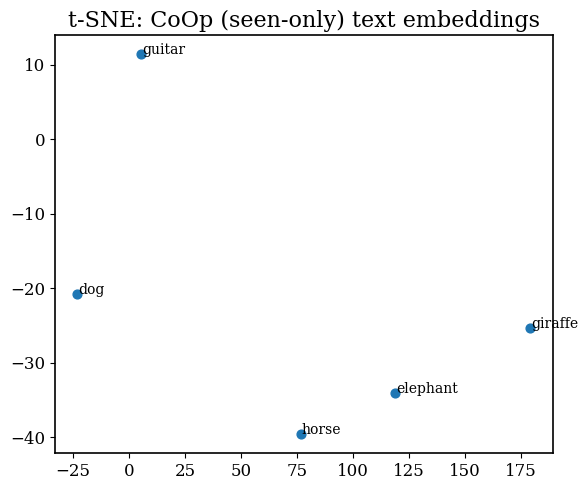

In [44]:

def tsne_2d(X, perplexity=30, seed=42):
    """
    Safe t-SNE wrapper that adjusts perplexity to be valid for small N.
    X: (N, D) array-like
    """
    X = np.asarray(X, dtype=np.float32)
    n = X.shape[0]
    # perplexity must be < (n-1); use a conservative clamp for tiny N
    per = max(2, min(perplexity, (n - 1) // 3 if n > 3 else 2))
    tsne = TSNE(
        n_components=2,
        init="pca",
        perplexity=per,
        learning_rate="auto",
        random_state=seed,
    )
    return tsne.fit_transform(X)

@torch.no_grad()
def collect_image_embeddings_for_tsne(loader, max_per_class=80):
    """
    Collect up to max_per_class image embeddings per class from loader.
    Returns: X (N,D), y (N,)
    """
    counts = {i: 0 for i in range(len(pacs_classes))}
    feats, labels = [], []
    for imgs, lbs in loader:
        imgs = imgs.to(device)
        f = clip32.encode_image(imgs).float()
        f = F.normalize(f, dim=-1).cpu().numpy()
        lbs_np = lbs.numpy()
        for vec, lab in zip(f, lbs_np):
            lab = int(lab)
            if counts[lab] < max_per_class:
                feats.append(vec)
                labels.append(lab)
                counts[lab] += 1
        if all(counts[i] >= max_per_class for i in counts):
            break
    return np.stack(feats, axis=0), np.array(labels)

# 1) t-SNE of IMAGE embeddings (source P+A+C)
img_X, img_y = collect_image_embeddings_for_tsne(full_src_loader, max_per_class=80)
img_2d = tsne_2d(img_X, perplexity=30, seed=42)

plt.figure(figsize=(7, 6))
for ci in range(len(pacs_classes)):
    m = (img_y == ci)
    if m.any():
        plt.scatter(img_2d[m, 0], img_2d[m, 1], s=10, alpha=0.7, label=pacs_classes[ci])
plt.title("t-SNE: Image embeddings (source P + A + C)")
plt.legend(markerscale=2, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 2) t-SNE of ZERO-SHOT TEXT embeddings (generic prompt)
zs_2d = tsne_2d(zs_all_feats.cpu().numpy(), perplexity=5, seed=7)
plt.figure(figsize=(6, 5))
plt.scatter(zs_2d[:, 0], zs_2d[:, 1], s=40)
for i, cname in enumerate(pacs_classes):
    plt.text(zs_2d[i, 0] + 0.5, zs_2d[i, 1], cname, fontsize=10)
plt.title("t-SNE: Zero-shot text embeddings")
plt.tight_layout()
plt.show()

# 3) t-SNE of CoOp (SEEN-ONLY) TEXT embeddings
with torch.no_grad():
    coop_seen_feats_only = coop_seen().cpu().numpy()  # shape: [len(seen_classes), d]
coop_2d = tsne_2d(coop_seen_feats_only, perplexity=5, seed=9)
plt.figure(figsize=(6, 5))
plt.scatter(coop_2d[:, 0], coop_2d[:, 1], s=40)
for i, cname in enumerate(seen_classes):
    plt.text(coop_2d[i, 0] + 0.5, coop_2d[i, 1], cname, fontsize=10)
plt.title("t-SNE: CoOp (seen-only) text embeddings")
plt.tight_layout()
plt.show()

In [38]:
@torch.no_grad()
def unseen_open_set_stats(loader, text_feats, unseen_idxs, thresh=0.5):
    # returns MSP-FPR@thresh (fraction of unseen samples whose max_prob >= thresh),
    # and avg entropy on unseen samples
    tot=0; high_conf=0; ent_sum=0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        mask = [(int(l.item()) in unseen_idxs) for l in labels]
        if not any(mask): continue
        f = clip32.encode_image(imgs).float(); f = f / f.norm(dim=-1, keepdim=True)
        logits = (f @ text_feats.T) * clip32.logit_scale.exp()
        probs = F.softmax(logits, dim=1)
        maxp, _ = probs.max(dim=1)
        ent = -(probs * (probs+1e-12).log()).sum(dim=1)
        for i,m in enumerate(mask):
            if m:
                tot += 1
                if maxp[i].item() >= thresh: high_conf += 1
                ent_sum += ent[i].item()
    if tot == 0: return 0.0, 0.0
    return high_conf/tot, ent_sum/tot

@torch.no_grad()
def msp_list(loader, text_feats, keep_label_idx=None):
    """Return MSP scores for samples whose labels ∈ keep_label_idx (or all if None)."""
    scores = []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        if keep_label_idx is not None:
            mask = torch.tensor([int(l.item()) in keep_label_idx for l in labels], device=device)
            if not mask.any():
                continue
        f = clip32.encode_image(imgs).float()
        f = f / f.norm(dim=-1, keepdim=True)
        logits = (f @ text_feats.T) * clip32.logit_scale.exp()
        probs = F.softmax(logits, dim=1)
        msp = probs.max(dim=1).values
        if keep_label_idx is not None:
            msp = msp[mask]
        scores.extend(msp.detach().cpu().tolist())
    return np.array(scores, dtype=np.float32)

def fpr_at_95_tpr(known_scores, unknown_scores):
    """
    Pick threshold so 95% of known scores are >= t (TPR=0.95).
    Return (FPR, threshold).
    """
    if len(known_scores) == 0 or len(unknown_scores) == 0:
        return 0.0, 0.0
    t = np.quantile(known_scores, 0.05)  # 5th percentile of known
    fpr = float((unknown_scores >= t).mean())
    return fpr, float(t)

In [39]:
methods = {
    "Zero-shot": zs_all_feats,
    "CoOp(seen-only)": coop_all_feats
}
results = {}
for name, feats in methods.items():
    per = per_class_acc(full_src_loader, feats)
    seen_acc   = float(np.mean([per[i] for i in seen_idxs]))
    unseen_acc = float(np.mean([per[i] for i in unseen_idxs]))
    overall    = float(np.mean(per))

    # Your fixed-threshold MSP & entropy (on unseen from sketch)
    fpr_fixed, avg_ent = unseen_open_set_stats(sketch_loader, feats, unseen_idxs, thresh=0.5)

    # FPR@95TPR using threshold picked on seen (source P+A+C)
    known_msp   = msp_list(full_src_loader, feats, keep_label_idx=seen_idxs)
    unknown_msp = msp_list(sketch_loader,   feats, keep_label_idx=unseen_idxs)
    fpr95, thr = fpr_at_95_tpr(known_msp, unknown_msp)

    results[name] = dict(
        seen=seen_acc, unseen=unseen_acc, overall=overall,
        msp_fpr=fpr_fixed, fpr95=fpr95, thr95=thr, avg_entropy=avg_ent
    )

print("\n=== Open-set / Seen–Unseen (Source eval) + OOD (Sketch, unseen classes) ===")
for name, r in results.items():
    print(f"{name:16s} | Seen: {r['seen']*100:5.2f}% | Unseen: {r['unseen']*100:5.2f}% | "
          f"Overall: {r['overall']*100:5.2f}% | MSP-FPR@0.5: {r['msp_fpr']*100:5.2f}% | "
          f"FPR@95TPR: {r['fpr95']*100:5.2f}% (thr={r['thr95']:.3f}) | Unseen Ent: {r['avg_entropy']:.3f}")


=== Open-set / Seen–Unseen (Source eval) + OOD (Sketch, unseen classes) ===
Zero-shot        | Seen: 97.62% | Unseen: 98.52% | Overall: 97.88% | MSP-FPR@0.5: 95.83% | FPR@95TPR: 85.42% (thr=0.717) | Unseen Ent: 0.416
CoOp(seen-only)  | Seen: 95.62% | Unseen: 95.28% | Overall: 95.52% | MSP-FPR@0.5: 90.42% | FPR@95TPR: 90.42% (thr=0.507) | Unseen Ent: 0.508


In [40]:
def sample_k_per_class(dataset, k, allowed_idxs):
    # dataset is ImageFolder; iterate and pick up to k per class
    counts = defaultdict(int); selected=[]
    for i, t in enumerate(dataset.targets):
        t = int(t)
        if t in allowed_idxs and counts[t] < k:
            selected.append(i)
            counts[t]+=1
        if all([counts[c]>=k for c in allowed_idxs]): break
    return selected

k=5
sketch_ds = clip_loaders["sketch"].dataset
few_idx = sample_k_per_class(sketch_ds, k, seen_idxs)
few_ds = Subset(sketch_ds, few_idx)
few_loader = DataLoader(few_ds, batch_size=16, shuffle=True)

In [42]:
@torch.no_grad()
def eval_seen_on_sketch_full(prompt_module):
    """Accuracy on the entire sketch domain, restricted to seen classes."""
    prompt_module.eval()
    total, correct = 0, 0
    for imgs, labels in sketch_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        mask = torch.tensor([int(l.item()) in seen_idxs for l in labels], device=device)
        if not mask.any():
            continue
        imgs = imgs[mask]; labels = labels[mask]
        img_feats = clip32.encode_image(imgs).float()
        img_feats = F.normalize(img_feats, dim=-1)

        # map original labels -> seen indices
        mapped = torch.tensor([seen_map[int(l.item())] for l in labels], device=device)

        text_feats = prompt_module()
        logits = clip32.logit_scale.exp() * (img_feats @ text_feats.T)
        preds = logits.argmax(1)
        total += mapped.size(0)
        correct += (preds == mapped).sum().item()
    return 100.0 * correct / max(total, 1)



coop_target = PromptLearner(seen_classes, clip32, ctx_len=4).to(device)
with torch.no_grad():
    coop_target.ctx.copy_(coop_seen.ctx)  # init from source CoOp

# fine-tune ctx only
seen_map = {orig: i for i, orig in enumerate(seen_idxs)}
opt = torch.optim.Adam([coop_target.ctx], lr=3e-4, weight_decay=5e-5)
epochs_ft = 5

for ep in range(epochs_ft):
    coop_target.train()
    tot, corr = 0, 0
    for imgs, labels in few_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        mapped = torch.tensor([seen_map[int(l.item())] for l in labels], device=device)

        with torch.no_grad():
            img_feats = clip32.encode_image(imgs).float()
        img_feats = F.normalize(img_feats, dim=-1)

        text_feats = coop_target()
        logits = clip32.logit_scale.exp() * (img_feats @ text_feats.T)
        loss = F.cross_entropy(logits, mapped, label_smoothing=0.1)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_([coop_target.ctx], 1.0)
        opt.step()

        preds = logits.argmax(1)
        tot += mapped.size(0); corr += (preds == mapped).sum().item()

    tr_acc = 100.0 * corr / max(tot, 1)
    val_acc = eval_seen_on_sketch_full(coop_target)
    print(f"Few-shot ep {ep+1}/{epochs_ft} | Train acc (fewset): {tr_acc:.2f}% | "
          f"Sketch(seen) acc (full): {val_acc:.2f}%")

# drift summary
src_ctx = coop_seen.ctx.detach().reshape(-1).double().cpu()
tgt_ctx = coop_target.ctx.detach().reshape(-1).double().cpu()
cos_sim = F.cosine_similarity(src_ctx, tgt_ctx, dim=0).item()
rel_l2  = (tgt_ctx - src_ctx).norm().item() / (src_ctx.norm().item() + 1e-12)
print(f"\nCosine similarity (source vs few-shot target ctx): {cos_sim:.6f}")
print(f"Relative L2 change in ctx: {rel_l2:.6e}")

Few-shot ep 1/5 | Train acc (fewset): 92.00% | Sketch(seen) acc (full): 85.77%
Few-shot ep 2/5 | Train acc (fewset): 92.00% | Sketch(seen) acc (full): 86.36%
Few-shot ep 3/5 | Train acc (fewset): 92.00% | Sketch(seen) acc (full): 86.69%
Few-shot ep 4/5 | Train acc (fewset): 100.00% | Sketch(seen) acc (full): 86.47%
Few-shot ep 5/5 | Train acc (fewset): 100.00% | Sketch(seen) acc (full): 86.15%

Cosine similarity (source vs few-shot target ctx): 0.996169
Relative L2 change in ctx: 8.767903e-02
